In [1]:
import matplotlib
print(matplotlib.__version__)

3.1.0


### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import librosa #python package for music and audio analysis
import matplotlib.pyplot as plt #we want to display the signals of one of the file
import IPython.display as ipd
import librosa.display
import seaborn

from tqdm import tqdm
import os

from datetime import datetime 

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder() #label encoding
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation

#### Set path

In [3]:
audio_dataset_path = r'C:\Users\Utente\Desktop\UniMi\Machine_Learning\ML_Project\UrbanSound8K'
audio_fold_path = r'C:\Users\Utente\Desktop\UniMi\Machine_Learning\ML_Project\UrbanSound8K\audio'
# metadata file
metadata = pd.read_csv(os.path.abspath(audio_dataset_path) +'\\' + str('metadata')+'\\'+str('UrbanSound8K.csv'))

## Dataset Description

In [4]:
metadata.head(5)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [5]:
metadata['class'].value_counts()

air_conditioner     1000
street_music        1000
jackhammer          1000
drilling            1000
engine_idling       1000
children_playing    1000
dog_bark            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

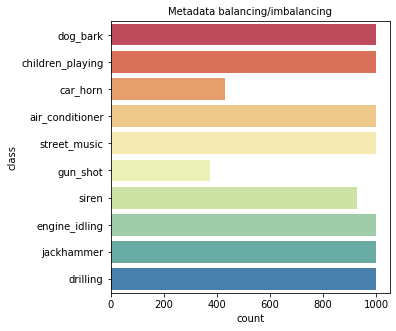

In [6]:
# check if metadata db is unbalanced

plt.figure(figsize=(5,5))
seaborn.countplot(y = metadata['class'],
                  palette = 'Spectral')
plt.title('Metadata balancing/imbalancing', fontsize=10)
plt.show()

In [7]:
labels = list(metadata['class'].unique())
labels.sort()

In [8]:
ex_audio = os.path.abspath(audio_fold_path) +'\\'+str('fold3')+'\\'+str('17973-2-0-21.wav')

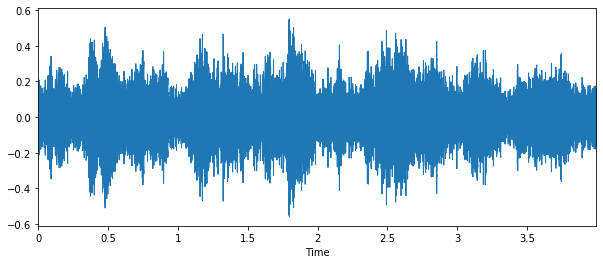

In [9]:
# Example of audio (childer_playing)
plt.figure(figsize=(10,4))
data, sr = librosa.load(ex_audio)
librosa.display.waveplot(data, sr = sr)
ipd.Audio(ex_audio)

## Audio features visualization

### MFCCs

[Text(0.5, 1.0, 'MFCC')]

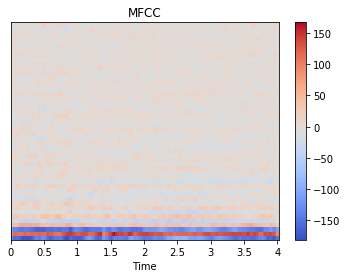

In [10]:
audio, sr = librosa.load(ex_audio)
mfccs = librosa.feature.mfcc(y = audio, sr=sr, n_mfcc=50)
fig, ax = plt.subplots(1,1)
img = librosa.display.specshow(mfccs, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC')

### Mel-Spectogram

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

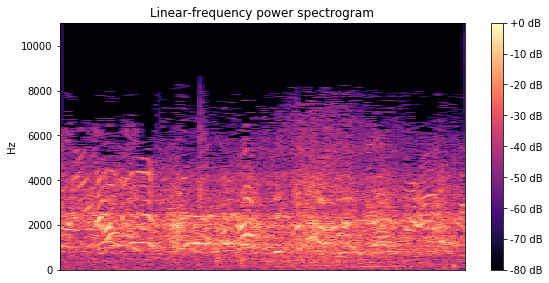

In [11]:
plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
plt.subplot(2,2,1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

### Chromagram

[Text(0.5, 1.0, 'Chromagram')]

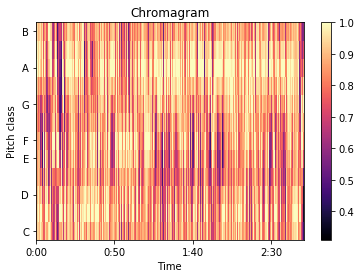

In [12]:
audio, sr = librosa.load(ex_audio)
librosa.feature.chroma_stft(y=audio, sr=sr)
S = np.abs(librosa.stft(audio, n_fft=50))
chroma = librosa.feature.chroma_stft(S=S, sr=sr)
fig, ax = plt.subplots()
img = librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='Chromagram')

## Features Extraction - Functions

In [13]:
def extract_mfcc(file_audio):
    data, sample_rate = librosa.load(file_audio,  res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=50)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    
    return mfccs_scaled_features

In [14]:
def extract_mel(file_audio):
    audio, sr = librosa.load(file_audio, res_type = 'kaiser_fast')
    mel_f = librosa.feature.melspectrogram(y = audio, sr = sr, n_mels = 50)
    mel_scaled_f = np.mean(mel_f.T, axis = 0)
    return mel_scaled_f 

In [15]:
def extract_chroma(file_audio):
    audio, sr = librosa.load(file_audio, res_type = 'kaiser_fast')
    chroma_f = librosa.feature.chroma_stft(y = audio, sr = sr, n_chroma = 50)
    chroma_scaled_f = np.mean(chroma_f.T, axis = 0)
    return chroma_scaled_f

In [16]:
# Functions to calculate the average accuracy given each of the 5 folds used for testing
def accuracy_avg(model):
    acc5 = model.evaluate(X_5, y_5)
    acc7 = model.evaluate(X_7, y_7)
    acc8 = model.evaluate(X_8, y_8)
    acc9 = model.evaluate(X_9, y_9)
    acc10 = model.evaluate(X_10, y_10)
    accuracy_avg = [acc5[1],acc7[1],acc8[1],acc9[1],acc10[1]]
    
    return accuracy_avg

# Model Creation

In [17]:
# number of our classes
n_labels = 10

## Model 1

In [187]:
def model1():
    m1 = tf.keras.Sequential([
        tf.keras.layers.Dense(256, input_shape = (50,)),
        tf.keras.layers.Dense(512, activation = 'relu'),
        tf.keras.layers.Dense(256, activation = 'relu'),
        tf.keras.layers.Dense(127, activation = 'relu'),
        tf.keras.layers.Dense((n_labels), activation = 'softmax')    
    ])
    
    m1.compile(loss = 'categorical_crossentropy',
              metrics = ['accuracy'],
              optimizer = 'adam' 
    )
    
    return m1

## Model 2

In [183]:
def model2():
    m2 = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='relu', input_shape=(50,)),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense((n_labels), activation = 'softmax')
    ])
    
    m2.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam'
    )
    
    return m2

## Model 3

In [20]:
def model3():
    m3 = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='relu', input_shape=(50,)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense((n_labels), activation = 'softmax')
    ])
    
    m3.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam'
    )
    
    return m3

# Creation of train and test set for our analysis

In [21]:
start = datetime.now()
train_mfcc = []
train_mels = []
train_chroma = []

n = [1,2,3,4,6]

for i in n:
    for index_num, row in tqdm(metadata.iterrows()):
        file_name = os.path.join(os.path.abspath(audio_fold_path) + '\\' + str('fold') + str(i) + '\\' + str(row["slice_file_name"]))
        if (str(row["fold"]) == str(i)):
            label_class = row["class"]
            #Extracting MFCCs
            data_mfcc = extract_mfcc(file_name)
            train_mfcc.append([data_mfcc, label_class])
            #Extracting Mels
            data_mels = extract_mel(file_name)
            train_mels.append([data_mels, label_class])  
            #Extracting Chroma
            data_chroma = extract_chroma(file_name)
            train_chroma.append([data_chroma, label_class])  

duration = datetime.now() - start
print("Extraction takes: ", duration)

1826it [00:50, 93.45it/s] C:\Users\Utente\Anaconda3\lib\site-packages\librosa\core\pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")
8323it [03:23, 119.41it/s]C:\Users\Utente\Anaconda3\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1103
  n_fft, y.shape[-1]
C:\Users\Utente\Anaconda3\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1323
  n_fft, y.shape[-1]
C:\Users\Utente\Anaconda3\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1523
  n_fft, y.shape[-1]
8732it [03:29, 41.74it/s] 
8732it [03:14, 44.79it/s] 
8732it [03:18, 44.00it/s] 
8732it [03:34, 40.69it/s] 
8732it [02:55, 49.69it/s] 

Extraction takes:  0:16:32.908632


In [22]:
start = datetime.now()
test_mfcc = []
test_mels = []
test_chroma = []

m = [5,7,8,9,10]

for i in m:
    for index_num, row in tqdm(metadata.iterrows()):
        file_name = os.path.join(os.path.abspath(audio_fold_path) + '\\' + str('fold') + str(i) + '\\' + str(row["slice_file_name"]))
        if (str(row["fold"]) == str(i)):
            fold = row["fold"]
            label_class = row["class"]
            #Extracting MFCCs
            data_mfcc = extract_mfcc(file_name)
            test_mfcc.append([data_mfcc, label_class,fold])
            #Extracting Mels
            data_mels = extract_mel(file_name)
            test_mels.append([data_mels, label_class,fold])
            #Extracting Chroma
            data_chroma = extract_chroma(file_name)
            test_chroma.append([data_chroma, label_class,fold])
            
duration = datetime.now() - start
print("Extraction takes: ", duration) 

8732it [03:37, 40.18it/s] 
8732it [02:50, 51.21it/s] 
8732it [02:54, 50.07it/s] 
8732it [02:46, 52.36it/s] 
8732it [02:56, 49.53it/s] 

Extraction takes:  0:15:05.350899


# MFCCs Analysis

In [173]:
train_mfcc_df=pd.DataFrame(train_mfcc,columns=['features','class'])
print(train_mfcc_df.shape)
train_mfcc_df.head(5)

(4499, 2)


,features,class
0,"[-403.96762, 94.398056, 17.75182, -11.521065, ...",dog_bark
1,"[-368.11002, 128.74481, 28.91274, -21.190063, ...",dog_bark
2,"[-422.47903, 70.38345, 9.934866, 0.0006177825,...",dog_bark
3,"[-260.24, 109.35184, -51.811287, -4.2874146, -...",dog_bark
4,"[-386.7848, 132.62964, 25.220673, 22.799538, -...",gun_shot


In [174]:
test_mfcc_df=pd.DataFrame(test_mfcc,columns=['features','class','fold'])
test_mfcc_df.head(5)

,features,class,fold
0,"[-215.793, 71.66612, -131.81377, -52.091335, -...",dog_bark,5
1,"[-424.68686, 110.562294, -54.14824, 62.01074, ...",children_playing,5
2,"[-459.56473, 122.80033, -47.924713, 53.265697,...",children_playing,5
3,"[-414.55374, 102.89688, -36.664955, 54.18041, ...",children_playing,5
4,"[-447.39703, 115.0954, -53.809113, 61.608585, ...",children_playing,5


In [175]:
test_mfcc_tot = test_mfcc_df.drop(columns=['fold'])

In [176]:
fold5_mfcc_df = test_mfcc_df[(test_mfcc_df['fold'] == 5)].drop(columns=['fold'])
fold7_mfcc_df = test_mfcc_df[(test_mfcc_df['fold'] == 7)].drop(columns=['fold'])
fold8_mfcc_df = test_mfcc_df[(test_mfcc_df['fold'] == 8)].drop(columns=['fold'])
fold9_mfcc_df = test_mfcc_df[(test_mfcc_df['fold'] == 9)].drop(columns=['fold'])
fold10_mfcc_df = test_mfcc_df[(test_mfcc_df['fold'] == 10)].drop(columns=['fold'])
fold8_mfcc_df.head(5)

,features,class
1774,"[-436.55283, 59.230797, -4.365659, -18.696339,...",dog_bark
1775,"[-384.40604, 81.117325, -18.265043, -36.135178...",dog_bark
1776,"[-389.85953, 103.61003, -16.540577, -37.49568,...",dog_bark
1777,"[-109.96019, 107.78428, -61.343327, 23.043413,...",engine_idling
1778,"[-105.101814, 102.80279, -53.661724, 22.275358...",engine_idling


In [177]:
X_train = np.array(train_mfcc_df['features'].tolist())
y_train = np.array(train_mfcc_df['class'].tolist())

In [178]:
X_test = np.array(test_mfcc_tot['features'].tolist())
y_test = np.array(test_mfcc_tot['class'].tolist())

In [179]:
X_5 = np.array(fold5_mfcc_df['features'].tolist())
y_5 = np.array(fold5_mfcc_df['class'].tolist())

X_7 = np.array(fold7_mfcc_df['features'].tolist())
y_7 = np.array(fold7_mfcc_df['class'].tolist())

X_8 = np.array(fold8_mfcc_df['features'].tolist())
y_8 = np.array(fold8_mfcc_df['class'].tolist())

X_9 = np.array(fold9_mfcc_df['features'].tolist())
y_9 = np.array(fold9_mfcc_df['class'].tolist())

X_10 = np.array(fold10_mfcc_df['features'].tolist())
y_10 = np.array(fold10_mfcc_df['class'].tolist())

In [180]:
# Label encoding, because label are categorical and we need a vector of 0,1 where 1 is related with the presence of that label
y_train = to_categorical(labelencoder.fit_transform(y_train))
y_test = to_categorical(labelencoder.fit_transform(y_test))
y_5 = to_categorical(labelencoder.fit_transform(y_5))
y_7 = to_categorical(labelencoder.fit_transform(y_7))
y_8 = to_categorical(labelencoder.fit_transform(y_8))
y_9 = to_categorical(labelencoder.fit_transform(y_9))
y_10 = to_categorical(labelencoder.fit_transform(y_10))

In [185]:
m1 = model1()
history = m1.fit(X_train, y_train, epochs = 100, batch_size = 32, verbose = 1)

Train on 4499 samples
Epoch 1/100
4499/4499 [==============================] - 1s 259us/sample - loss: 2.2320 - accuracy: 0.3721
Epoch 2/100
4499/4499 [==============================] - 0s 107us/sample - loss: 1.3957 - accuracy: 0.5201
Epoch 3/100
4499/4499 [==============================] - 0s 103us/sample - loss: 1.1315 - accuracy: 0.6106
Epoch 4/100
4499/4499 [==============================] - 0s 110us/sample - loss: 1.0392 - accuracy: 0.6479
Epoch 5/100
4499/4499 [==============================] - 1s 129us/sample - loss: 0.8604 - accuracy: 0.7033 - loss: 0.9264 - 
Epoch 6/100
4499/4499 [==============================] - 1s 115us/sample - loss: 0.8254 - accuracy: 0.7248
Epoch 7/100
4499/4499 [==============================] - 1s 114us/sample - loss: 0.7234 - accuracy: 0.7611
Epoch 8/100
4499/4499 [==============================] - 0s 111us/sample - loss: 0.6660 - accuracy: 0.7751
Epoch 9/100
4499/4499 [==============================] - 0s 109us/sample - loss: 0.5742 - accuracy: 0.80

4499/4499 [==============================] - 0s 96us/sample - loss: 0.0383 - accuracy: 0.9893
Epoch 77/100
4499/4499 [==============================] - 1s 121us/sample - loss: 0.0355 - accuracy: 0.9893
Epoch 78/100
4499/4499 [==============================] - 0s 108us/sample - loss: 0.0292 - accuracy: 0.9902
Epoch 79/100
4499/4499 [==============================] - 0s 104us/sample - loss: 0.0110 - accuracy: 0.9976
Epoch 80/100
4499/4499 [==============================] - 0s 91us/sample - loss: 0.0058 - accuracy: 0.9984
Epoch 81/100
4499/4499 [==============================] - 1s 119us/sample - loss: 0.0039 - accuracy: 0.9991
Epoch 82/100
4499/4499 [==============================] - 0s 100us/sample - loss: 0.0039 - accuracy: 0.9993
Epoch 83/100
4499/4499 [==============================] - 1s 143us/sample - loss: 0.0046 - accuracy: 0.9991
Epoch 84/100
4499/4499 [==============================] - 1s 150us/sample - loss: 0.0040 - accuracy: 0.9993
Epoch 85/100
4499/4499 [===================

In [186]:
model = m1
score_m1 = accuracy_avg(m1)
print((np.mean(score_m1), np.std(score_m1)))

837/837 [==============================] - 0s 75us/sample - loss: 5.9539 - accuracy: 0.4827
(0.48356986, 0.022868194)


In [43]:
m2 = model2()
history = m2.fit(X_train, y_train, epochs = 100,  batch_size = 32, verbose = 1)

Train on 4499 samples
Epoch 1/100
4499/4499 [==============================] - 2s 348us/sample - loss: 1.8423 - accuracy: 0.4292
Epoch 2/100
4499/4499 [==============================] - 1s 160us/sample - loss: 1.0825 - accuracy: 0.6279
Epoch 3/100
4499/4499 [==============================] - 1s 172us/sample - loss: 0.8343 - accuracy: 0.7188
Epoch 4/100
4499/4499 [==============================] - 1s 166us/sample - loss: 0.6902 - accuracy: 0.7595
Epoch 5/100
4499/4499 [==============================] - 1s 187us/sample - loss: 0.5682 - accuracy: 0.8053
Epoch 6/100
4499/4499 [==============================] - 1s 171us/sample - loss: 0.4609 - accuracy: 0.8431
Epoch 7/100
4499/4499 [==============================] - 1s 165us/sample - loss: 0.3715 - accuracy: 0.8664
Epoch 8/100
4499/4499 [==============================] - 1s 183us/sample - loss: 0.3039 - accuracy: 0.8926
Epoch 9/100
4499/4499 [==============================] - 1s 186us/sample - loss: 0.2650 - accuracy: 0.9080
Epoch 10/100
44

4499/4499 [==============================] - 1s 193us/sample - loss: 0.0534 - accuracy: 0.9853
Epoch 77/100
4499/4499 [==============================] - 1s 180us/sample - loss: 0.0120 - accuracy: 0.9962
Epoch 78/100
4499/4499 [==============================] - 1s 167us/sample - loss: 0.0030 - accuracy: 0.9993
Epoch 79/100
4499/4499 [==============================] - 1s 146us/sample - loss: 0.0016 - accuracy: 0.9993
Epoch 80/100
4499/4499 [==============================] - 1s 143us/sample - loss: 0.0015 - accuracy: 0.9996
Epoch 81/100
4499/4499 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 0.99 - 1s 148us/sample - loss: 0.0014 - accuracy: 0.9996
Epoch 82/100
4499/4499 [==============================] - 1s 142us/sample - loss: 0.0013 - accuracy: 0.9993
Epoch 83/100
4499/4499 [==============================] - 1s 156us/sample - loss: 0.0013 - accuracy: 0.99960s - loss: 0.0
Epoch 84/100
4499/4499 [==============================] - 1s 188us/sample - loss: 0.0011 - ac

In [44]:
model = m2
score_m2 = accuracy_avg(m2)
print((np.mean(score_m2), np.std(score_m2)))

837/837 [==============================] - 0s 80us/sample - loss: 5.3430 - accuracy: 0.4707
(0.5124992, 0.022774138)


In [160]:
m3 = model3()
history = m3.fit(X_train, y_train, epochs = 100,  batch_size = 32, verbose = 1)

Train on 4499 samples
Epoch 1/100
4499/4499 [==============================] - 2s 413us/sample - loss: 2.3446 - accuracy: 0.1783
Epoch 2/100
4499/4499 [==============================] - 1s 220us/sample - loss: 2.1362 - accuracy: 0.2761
Epoch 3/100
4499/4499 [==============================] - 1s 219us/sample - loss: 1.9293 - accuracy: 0.3536
Epoch 4/100
4499/4499 [==============================] - 1s 229us/sample - loss: 1.8107 - accuracy: 0.3788
Epoch 5/100
4499/4499 [==============================] - 1s 229us/sample - loss: 1.6462 - accuracy: 0.4392
Epoch 6/100
4499/4499 [==============================] - 1s 227us/sample - loss: 1.5657 - accuracy: 0.4690
Epoch 7/100
4499/4499 [==============================] - 1s 224us/sample - loss: 1.4771 - accuracy: 0.4986
Epoch 8/100
4499/4499 [==============================] - 1s 236us/sample - loss: 1.3955 - accuracy: 0.5357
Epoch 9/100
4499/4499 [==============================] - 1s 232us/sample - loss: 1.3095 - accuracy: 0.5652
Epoch 10/100
44

4499/4499 [==============================] - 1s 227us/sample - loss: 0.3448 - accuracy: 0.8924
Epoch 77/100
4499/4499 [==============================] - 1s 229us/sample - loss: 0.3533 - accuracy: 0.8911
Epoch 78/100
4499/4499 [==============================] - 1s 270us/sample - loss: 0.3093 - accuracy: 0.9020
Epoch 79/100
4499/4499 [==============================] - 1s 321us/sample - loss: 0.3108 - accuracy: 0.9033
Epoch 80/100
4499/4499 [==============================] - 1s 248us/sample - loss: 0.3088 - accuracy: 0.9026
Epoch 81/100
4499/4499 [==============================] - 1s 248us/sample - loss: 0.3106 - accuracy: 0.9040
Epoch 82/100
4499/4499 [==============================] - 1s 261us/sample - loss: 0.2981 - accuracy: 0.9080
Epoch 83/100
4499/4499 [==============================] - 2s 374us/sample - loss: 0.2748 - accuracy: 0.9102 - loss: 0.2778 - accuracy - ETA: 0s - loss:
Epoch 84/100
4499/4499 [==============================] - 1s 265us/sample - loss: 0.2871 - accuracy: 0.90

In [40]:
model = m3
score_m3 = accuracy_avg(m3)
print((np.mean(score_m3), np.std(score_m3)))

837/837 [==============================] - 0s 82us/sample - loss: 3.5500 - accuracy: 0.5161
(0.52668947, 0.032276)


In [45]:
df1 = pd.DataFrame({'Avg Accuracy':[str(round(np.mean(score_m1)*100, 2))+'%', str(round(np.mean(score_m2)*100, 2))+'%', str(round(np.mean(score_m3)*100, 2))+'%'],
                   'Std':[str(round(np.std(score_m1), 4)), str(round(np.std(score_m2), 4)), str(round(np.std(score_m3), 4))]},
                 index=['Model 1', 'Model 2', 'Model 3']) 
df1

,Avg Accuracy,Std
Model 1,48.37%,0.026
Model 2,51.25%,0.0228
Model 3,52.67%,0.0323


In [46]:
y_pred = m3.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

print(classification_report(y_test_, y_pred, target_names = labels))

                  precision    recall  f1-score   support

 air_conditioner       0.48      0.31      0.38       500
        car_horn       0.95      0.72      0.82       221
children_playing       0.40      0.62      0.48       500
        dog_bark       0.50      0.65      0.57       500
        drilling       0.48      0.47      0.48       500
   engine_idling       0.78      0.45      0.57       483
        gun_shot       0.46      0.57      0.51       184
      jackhammer       0.54      0.36      0.43       452
           siren       0.68      0.67      0.67       393
    street_music       0.47      0.59      0.52       500

        accuracy                           0.53      4233
       macro avg       0.57      0.54      0.54      4233
    weighted avg       0.55      0.53      0.53      4233



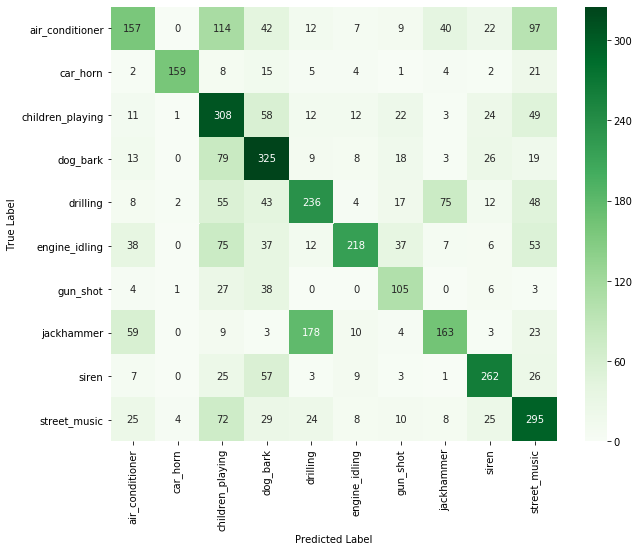

In [47]:
cm  = confusion_matrix(y_test_, y_pred)
plt.figure(figsize= (10,8))
seaborn.heatmap(cm, annot = True, xticklabels = labels , yticklabels = labels, cmap ='Greens', fmt='g' )
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [49]:
m3 =  model3()
best_mfcc = m3.fit(X_train, y_train, epochs=100, batch_size = 32, validation_data = (X_test, y_test), verbose=1)

Train on 4499 samples, validate on 4233 samples
Epoch 1/100
4499/4499 [==============================] - 2s 543us/sample - loss: 2.8621 - accuracy: 0.1525 - val_loss: 2.1924 - val_accuracy: 0.2195
Epoch 2/100
4499/4499 [==============================] - 1s 300us/sample - loss: 2.0644 - accuracy: 0.2483 - val_loss: 2.1118 - val_accuracy: 0.2587
Epoch 3/100
4499/4499 [==============================] - 1s 294us/sample - loss: 1.9430 - accuracy: 0.2970 - val_loss: 2.0304 - val_accuracy: 0.2970
Epoch 4/100
4499/4499 [==============================] - 2s 390us/sample - loss: 1.7592 - accuracy: 0.3581 - val_loss: 2.0323 - val_accuracy: 0.3414
Epoch 5/100
4499/4499 [==============================] - 2s 413us/sample - loss: 1.5973 - accuracy: 0.4230 - val_loss: 1.9159 - val_accuracy: 0.3950
Epoch 6/100
4499/4499 [==============================] - 1s 316us/sample - loss: 1.4182 - accuracy: 0.4857 - val_loss: 1.9050 - val_accuracy: 0.4295
Epoch 7/100
4499/4499 [==============================] - 1

4499/4499 [==============================] - 2s 337us/sample - loss: 0.1490 - accuracy: 0.9549 - val_loss: 3.8038 - val_accuracy: 0.5037
Epoch 56/100
4499/4499 [==============================] - 1s 291us/sample - loss: 0.1525 - accuracy: 0.9535 - val_loss: 3.8731 - val_accuracy: 0.5261
Epoch 57/100
4499/4499 [==============================] - 1s 274us/sample - loss: 0.1429 - accuracy: 0.9533 - val_loss: 3.8679 - val_accuracy: 0.5058
Epoch 58/100
4499/4499 [==============================] - 1s 287us/sample - loss: 0.1264 - accuracy: 0.9629 - val_loss: 4.1929 - val_accuracy: 0.5332
Epoch 59/100
4499/4499 [==============================] - 1s 291us/sample - loss: 0.1259 - accuracy: 0.9611 - val_loss: 4.3347 - val_accuracy: 0.5270
Epoch 60/100
4499/4499 [==============================] - 1s 304us/sample - loss: 0.1358 - accuracy: 0.9620 - val_loss: 4.3661 - val_accuracy: 0.5235
Epoch 61/100
4499/4499 [==============================] - 2s 342us/sample - loss: 0.1487 - accuracy: 0.9589 - val

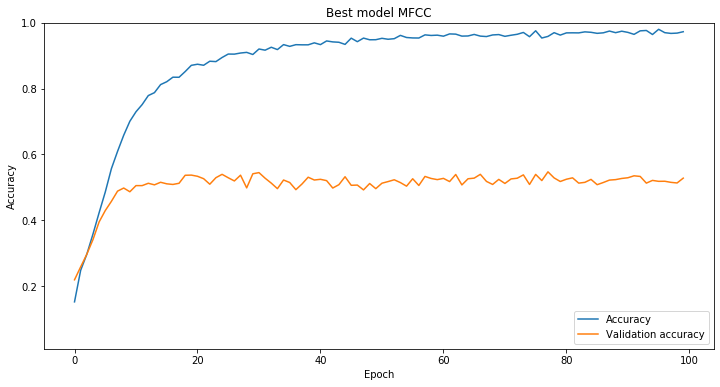

In [50]:
plt.figure(figsize=(12,6))
plt.title("Best model MFCC")
plt.plot(best_mfcc.history['accuracy'], label='Accuracy')
plt.plot(best_mfcc.history['val_accuracy'], label = 'Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.01, 1])
plt.legend(loc='lower right')
plt.savefig(os.path.abspath(audio_dataset_path) + '\\' + str('Best_mfcc.jpg'))

# Mel-Spectogram Analysis

In [116]:
train_mel_df=pd.DataFrame(train_mels,columns=['features','class'])
print(train_mel_df.shape)
train_mel_df.head(5)

(4499, 2)


,features,class
0,"[0.0066664177, 0.016760109, 0.19248646, 0.4563...",dog_bark
1,"[0.008534789, 0.029180555, 0.26235464, 0.73913...",dog_bark
2,"[0.010187269, 0.011007145, 0.0900943, 0.293082...",dog_bark
3,"[0.06910683, 0.038908355, 0.019400986, 0.01186...",dog_bark
4,"[3.3364396, 0.56877035, 0.26730633, 0.2775878,...",gun_shot


In [117]:
test_mel_df=pd.DataFrame(test_mels,columns=['features','class','fold'])
test_mel_df.head(5)

,features,class,fold
0,"[0.00028046934, 0.00097357325, 0.0037169198, 0...",dog_bark,5
1,"[0.04168589, 0.01527811, 0.0039165574, 0.00260...",children_playing,5
2,"[0.030956212, 0.013500806, 0.003484583, 0.0022...",children_playing,5
3,"[0.03694177, 0.040530685, 0.008233039, 0.00367...",children_playing,5
4,"[0.03365683, 0.01202265, 0.0041175466, 0.00246...",children_playing,5


In [118]:
test_mel_tot = test_mel_df.drop(columns=['fold'])

In [119]:
fold5_mel_df = test_mel_df[(test_mel_df['fold'] == 5)].drop(columns=['fold'])
fold7_mel_df = test_mel_df[(test_mel_df['fold'] == 7)].drop(columns=['fold'])
fold8_mel_df = test_mel_df[(test_mel_df['fold'] == 8)].drop(columns=['fold'])
fold9_mel_df = test_mel_df[(test_mel_df['fold'] == 9)].drop(columns=['fold'])
fold10_mel_df = test_mel_df[(test_mel_df['fold'] == 10)].drop(columns=['fold'])
fold5_mel_df.head(5)

,features,class
0,"[0.00028046934, 0.00097357325, 0.0037169198, 0...",dog_bark
1,"[0.04168589, 0.01527811, 0.0039165574, 0.00260...",children_playing
2,"[0.030956212, 0.013500806, 0.003484583, 0.0022...",children_playing
3,"[0.03694177, 0.040530685, 0.008233039, 0.00367...",children_playing
4,"[0.03365683, 0.01202265, 0.0041175466, 0.00246...",children_playing


In [120]:
X_train = np.array(train_mel_df['features'].tolist())
y_train = np.array(train_mel_df['class'].tolist())

In [121]:
X_test = np.array(test_mel_tot['features'].tolist())
y_test = np.array(test_mel_tot['class'].tolist())

In [122]:
X_5 = np.array(fold5_mel_df['features'].tolist())
y_5 = np.array(fold5_mel_df['class'].tolist())

X_7 = np.array(fold7_mel_df['features'].tolist())
y_7 = np.array(fold7_mel_df['class'].tolist())

X_8 = np.array(fold8_mel_df['features'].tolist())
y_8 = np.array(fold8_mel_df['class'].tolist())

X_9 = np.array(fold9_mel_df['features'].tolist())
y_9 = np.array(fold9_mel_df['class'].tolist())

X_10 = np.array(fold10_mel_df['features'].tolist())
y_10 = np.array(fold10_mel_df['class'].tolist())

In [123]:
# Label encoding, because label are categorical and we need a vector of 0,1 where 1 is related with the presence of that label
y_train = to_categorical(labelencoder.fit_transform(y_train))
y_test = to_categorical(labelencoder.fit_transform(y_test))
y_5 = to_categorical(labelencoder.fit_transform(y_5))
y_7 = to_categorical(labelencoder.fit_transform(y_7))
y_8 = to_categorical(labelencoder.fit_transform(y_8))
y_9 = to_categorical(labelencoder.fit_transform(y_9))
y_10 = to_categorical(labelencoder.fit_transform(y_10))

In [59]:
m1 = model1()
history = m1.fit(X_train, y_train, epochs = 100, batch_size = 32, verbose = 1)

Train on 4499 samples
Epoch 1/100
4499/4499 [==============================] - 2s 367us/sample - loss: 2.4007 - accuracy: 0.3245
Epoch 2/100
4499/4499 [==============================] - 1s 212us/sample - loss: 1.8186 - accuracy: 0.4303
Epoch 3/100
4499/4499 [==============================] - 1s 213us/sample - loss: 1.6974 - accuracy: 0.4483
Epoch 4/100
4499/4499 [==============================] - 1s 195us/sample - loss: 1.5525 - accuracy: 0.4828
Epoch 5/100
4499/4499 [==============================] - 1s 190us/sample - loss: 1.4107 - accuracy: 0.5317
Epoch 6/100
4499/4499 [==============================] - 1s 180us/sample - loss: 1.3434 - accuracy: 0.5672
Epoch 7/100
4499/4499 [==============================] - 1s 175us/sample - loss: 1.2398 - accuracy: 0.6064
Epoch 8/100
4499/4499 [==============================] - 1s 182us/sample - loss: 1.1580 - accuracy: 0.6339
Epoch 9/100
4499/4499 [==============================] - 1s 183us/sample - loss: 1.1471 - accuracy: 0.6297
Epoch 10/100
44

4499/4499 [==============================] - 1s 195us/sample - loss: 0.1721 - accuracy: 0.9475
Epoch 77/100
4499/4499 [==============================] - 1s 163us/sample - loss: 0.1776 - accuracy: 0.9438
Epoch 78/100
4499/4499 [==============================] - 1s 169us/sample - loss: 0.1801 - accuracy: 0.9418
Epoch 79/100
4499/4499 [==============================] - 1s 187us/sample - loss: 0.2446 - accuracy: 0.9287
Epoch 80/100
4499/4499 [==============================] - 1s 217us/sample - loss: 0.2783 - accuracy: 0.9138
Epoch 81/100
4499/4499 [==============================] - 1s 217us/sample - loss: 0.3457 - accuracy: 0.9135
Epoch 82/100
4499/4499 [==============================] - 1s 187us/sample - loss: 0.3870 - accuracy: 0.8984
Epoch 83/100
4499/4499 [==============================] - 1s 216us/sample - loss: 0.2273 - accuracy: 0.9255
Epoch 84/100
4499/4499 [==============================] - 1s 209us/sample - loss: 0.2935 - accuracy: 0.9118
Epoch 85/100
4499/4499 [=================

In [60]:
model = m1
score_m4 = accuracy_avg(m1)
print((np.mean(score_m4), np.std(score_m4)))

837/837 [==============================] - 0s 101us/sample - loss: 8.0481 - accuracy: 0.4038
(0.39276648, 0.015677061)


In [61]:
m2 = model2()
history = m2.fit(X_train, y_train, epochs = 100, batch_size = 32, verbose = 1)

Train on 4499 samples
Epoch 1/100
4499/4499 [==============================] - 1s 298us/sample - loss: 2.1326 - accuracy: 0.3136
Epoch 2/100
4499/4499 [==============================] - 1s 167us/sample - loss: 1.8092 - accuracy: 0.4130
Epoch 3/100
4499/4499 [==============================] - 1s 165us/sample - loss: 1.5587 - accuracy: 0.4745
Epoch 4/100
4499/4499 [==============================] - 1s 166us/sample - loss: 1.3480 - accuracy: 0.5495
Epoch 5/100
4499/4499 [==============================] - 1s 181us/sample - loss: 1.2139 - accuracy: 0.5979
Epoch 6/100
4499/4499 [==============================] - 1s 181us/sample - loss: 1.1327 - accuracy: 0.6308
Epoch 7/100
4499/4499 [==============================] - 1s 164us/sample - loss: 0.9900 - accuracy: 0.6704
Epoch 8/100
4499/4499 [==============================] - 1s 191us/sample - loss: 0.8919 - accuracy: 0.6995
Epoch 9/100
4499/4499 [==============================] - 1s 192us/sample - loss: 0.8419 - accuracy: 0.7175
Epoch 10/100
44

4499/4499 [==============================] - 1s 216us/sample - loss: 0.0628 - accuracy: 0.9769
Epoch 76/100
4499/4499 [==============================] - 1s 265us/sample - loss: 0.0668 - accuracy: 0.9782
Epoch 77/100
4499/4499 [==============================] - 1s 241us/sample - loss: 0.0733 - accuracy: 0.9753
Epoch 78/100
4499/4499 [==============================] - 1s 177us/sample - loss: 0.1169 - accuracy: 0.9620
Epoch 79/100
4499/4499 [==============================] - 1s 190us/sample - loss: 0.2162 - accuracy: 0.9373
Epoch 80/100
4499/4499 [==============================] - 1s 158us/sample - loss: 0.1081 - accuracy: 0.9644
Epoch 81/100
4499/4499 [==============================] - 1s 163us/sample - loss: 0.0921 - accuracy: 0.9651
Epoch 82/100
4499/4499 [==============================] - 1s 156us/sample - loss: 0.0675 - accuracy: 0.9778
Epoch 83/100
4499/4499 [==============================] - 1s 151us/sample - loss: 0.0627 - accuracy: 0.9784
Epoch 84/100
4499/4499 [=================

In [62]:
model = m2
score_m5 = accuracy_avg(m2)
print((np.mean(score_m5), np.std(score_m5)))

837/837 [==============================] - 0s 79us/sample - loss: 4.8596 - accuracy: 0.4182
(0.43176022, 0.021454744)


In [63]:
m3 = model3()
history = m3.fit(X_train, y_train, epochs = 100, batch_size =32,  verbose = 1)

Train on 4499 samples
Epoch 1/100
4499/4499 [==============================] - 2s 463us/sample - loss: 2.3909 - accuracy: 0.2074
Epoch 2/100
4499/4499 [==============================] - 1s 207us/sample - loss: 2.0984 - accuracy: 0.2898
Epoch 3/100
4499/4499 [==============================] - 1s 208us/sample - loss: 1.9076 - accuracy: 0.3583
Epoch 4/100
4499/4499 [==============================] - 1s 222us/sample - loss: 1.7735 - accuracy: 0.3965
Epoch 5/100
4499/4499 [==============================] - 1s 219us/sample - loss: 1.6513 - accuracy: 0.4223
Epoch 6/100
4499/4499 [==============================] - 1s 218us/sample - loss: 1.5494 - accuracy: 0.4663
Epoch 7/100
4499/4499 [==============================] - 1s 211us/sample - loss: 1.4823 - accuracy: 0.4934
Epoch 8/100
4499/4499 [==============================] - 1s 226us/sample - loss: 1.3819 - accuracy: 0.5343
Epoch 9/100
4499/4499 [==============================] - 1s 213us/sample - loss: 1.3202 - accuracy: 0.5661
Epoch 10/100
44

Epoch 76/100
4499/4499 [==============================] - 1s 292us/sample - loss: 0.3243 - accuracy: 0.8993
Epoch 77/100
4499/4499 [==============================] - 1s 206us/sample - loss: 0.3235 - accuracy: 0.9011
Epoch 78/100
4499/4499 [==============================] - ETA: 0s - loss: 0.3321 - accuracy: 0.90 - 1s 219us/sample - loss: 0.3317 - accuracy: 0.9006
Epoch 79/100
4499/4499 [==============================] - 1s 241us/sample - loss: 0.3093 - accuracy: 0.9022
Epoch 80/100
4499/4499 [==============================] - 1s 227us/sample - loss: 0.3536 - accuracy: 0.9009
Epoch 81/100
4499/4499 [==============================] - 1s 202us/sample - loss: 0.3596 - accuracy: 0.8946
Epoch 82/100
4499/4499 [==============================] - 1s 204us/sample - loss: 0.3318 - accuracy: 0.8975
Epoch 83/100
4499/4499 [==============================] - 1s 220us/sample - loss: 0.3116 - accuracy: 0.9051
Epoch 84/100
4499/4499 [==============================] - 1s 261us/sample - loss: 0.2911 - acc

In [64]:
model = m3
score_m6 = accuracy_avg(m3)
print((np.mean(score_m6), np.std(score_m6)))

837/837 [==============================] - 0s 81us/sample - loss: 3.2188 - accuracy: 0.4456
(0.4576686, 0.020224897)


In [65]:
df2 = pd.DataFrame({'Avg Accuracy':[str(round(np.mean(score_m4)*100, 2))+'%', str(round(np.mean(score_m5)*100, 2))+'%', str(round(np.mean(score_m6)*100, 2))+'%'],
                   'Std':[str(round(np.std(score_m4), 4)), str(round(np.std(score_m5), 4)), str(round(np.std(score_m6), 4))]},
                 index=['Model 1', 'Model 2', 'Model 3']) 
df2

,Avg Accuracy,Std
Model 1,39.28%,0.0157
Model 2,43.18%,0.0215
Model 3,45.77%,0.0202


In [66]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

print(classification_report(y_test_, y_pred, target_names=labels))

                  precision    recall  f1-score   support

 air_conditioner       0.47      0.33      0.39       500
        car_horn       0.70      0.65      0.68       221
children_playing       0.39      0.46      0.42       500
        dog_bark       0.57      0.63      0.60       500
        drilling       0.33      0.41      0.36       500
   engine_idling       0.65      0.41      0.50       483
        gun_shot       0.32      0.48      0.38       184
      jackhammer       0.29      0.12      0.17       452
           siren       0.60      0.68      0.64       393
    street_music       0.40      0.55      0.46       500

        accuracy                           0.46      4233
       macro avg       0.47      0.47      0.46      4233
    weighted avg       0.47      0.46      0.45      4233



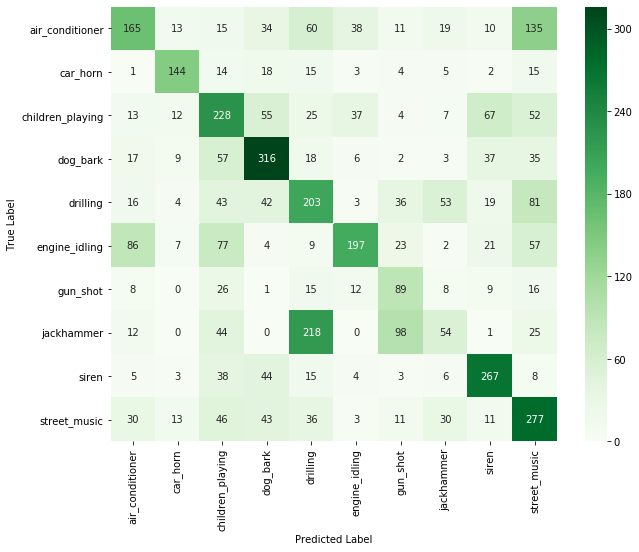

In [67]:
cm  = confusion_matrix(y_test_, y_pred)
plt.figure(figsize= (10,8))
seaborn.heatmap(cm, annot = True, xticklabels = labels, yticklabels = labels, cmap ='Greens', fmt='.3g' )
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [124]:
m3 =  model3()
best_mel = m3.fit(X_train, y_train, epochs=100, batch_size = 32, validation_data = (X_test, y_test), verbose=1)

Train on 4499 samples, validate on 4233 samples
Epoch 1/100
4499/4499 [==============================] - 2s 539us/sample - loss: 2.4069 - accuracy: 0.1905 - val_loss: 2.2031 - val_accuracy: 0.2228
Epoch 2/100
4499/4499 [==============================] - 1s 332us/sample - loss: 2.1724 - accuracy: 0.2587 - val_loss: 2.0738 - val_accuracy: 0.3005
Epoch 3/100
4499/4499 [==============================] - 1s 317us/sample - loss: 2.0135 - accuracy: 0.3205 - val_loss: 2.0322 - val_accuracy: 0.3024
Epoch 4/100
4499/4499 [==============================] - 1s 298us/sample - loss: 1.8444 - accuracy: 0.3725 - val_loss: 2.1184 - val_accuracy: 0.3102
Epoch 5/100
4499/4499 [==============================] - 1s 304us/sample - loss: 1.7393 - accuracy: 0.4052 - val_loss: 2.0803 - val_accuracy: 0.3591
Epoch 6/100
4499/4499 [==============================] - 1s 317us/sample - loss: 1.6111 - accuracy: 0.4545 - val_loss: 2.0080 - val_accuracy: 0.4085
Epoch 7/100
4499/4499 [==============================] - 2

4499/4499 [==============================] - 2s 361us/sample - loss: 0.4090 - accuracy: 0.8633 - val_loss: 4.1141 - val_accuracy: 0.4678
Epoch 56/100
4499/4499 [==============================] - 1s 317us/sample - loss: 0.4217 - accuracy: 0.8722 - val_loss: 4.0874 - val_accuracy: 0.4600
Epoch 57/100
4499/4499 [==============================] - 1s 318us/sample - loss: 0.3978 - accuracy: 0.8720 - val_loss: 4.2503 - val_accuracy: 0.4720
Epoch 58/100
4499/4499 [==============================] - 2s 339us/sample - loss: 0.3742 - accuracy: 0.8773 - val_loss: 3.7537 - val_accuracy: 0.4751
Epoch 59/100
4499/4499 [==============================] - 2s 354us/sample - loss: 0.3977 - accuracy: 0.8764 - val_loss: 4.1227 - val_accuracy: 0.4746
Epoch 60/100
4499/4499 [==============================] - 1s 303us/sample - loss: 0.4352 - accuracy: 0.8722 - val_loss: 3.6712 - val_accuracy: 0.4751
Epoch 61/100
4499/4499 [==============================] - 1s 326us/sample - loss: 0.3728 - accuracy: 0.8835 - val

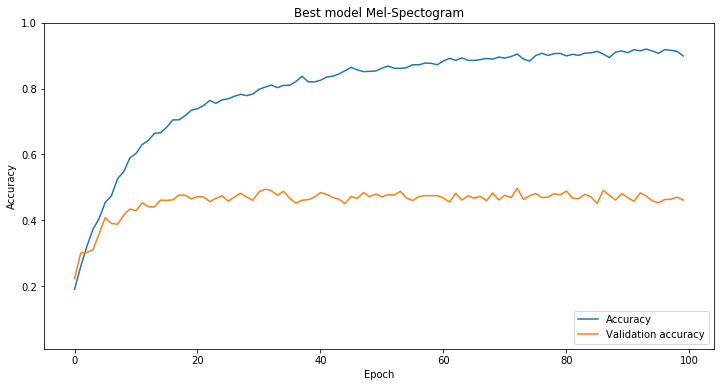

In [125]:
plt.figure(figsize=(12,6))
plt.title("Best model Mel-Spectogram")
plt.plot(best_mel.history['accuracy'], label='Accuracy')
plt.plot(best_mel.history['val_accuracy'], label = 'Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.01, 1])
plt.legend(loc='lower right')
plt.savefig(os.path.abspath(audio_dataset_path) + '\\' + str('Best_mel.jpg'))

# Chromagram Analysis

In [106]:
train_chroma_df=pd.DataFrame(train_chroma,columns=['features','class'])
print(train_chroma_df.shape)
train_chroma_df.head(5)

(4499, 2)


,features,class
0,"[0.37841558, 0.3484942, 0.3363871, 0.34200144,...",dog_bark
1,"[0.2477782, 0.25305223, 0.2752488, 0.30952737,...",dog_bark
2,"[0.50481457, 0.4862124, 0.46969366, 0.46402523...",dog_bark
3,"[0.29025888, 0.33982426, 0.3245475, 0.3034354,...",dog_bark
4,"[0.41994813, 0.3982322, 0.3743985, 0.36196926,...",gun_shot


In [107]:
test_chroma_df=pd.DataFrame(test_chroma,columns=['features','class','fold'])
test_chroma_df.head(5)

,features,class,fold
0,"[0.19260328, 0.11993427, 0.13590343, 0.2782782...",dog_bark,5
1,"[0.2942378, 0.3201279, 0.32567337, 0.29884523,...",children_playing,5
2,"[0.4074426, 0.4272451, 0.41552094, 0.3918716, ...",children_playing,5
3,"[0.37045616, 0.37686855, 0.36427298, 0.3883780...",children_playing,5
4,"[0.4910348, 0.48851535, 0.4879796, 0.52124643,...",children_playing,5


In [108]:
test_chroma_tot = test_chroma_df.drop(columns=['fold'])

In [109]:
fold5_chroma_df = test_chroma_df[(test_chroma_df['fold'] == 5)].drop(columns=['fold'])
fold7_chroma_df = test_chroma_df[(test_chroma_df['fold'] == 7)].drop(columns=['fold'])
fold8_chroma_df = test_chroma_df[(test_chroma_df['fold'] == 8)].drop(columns=['fold'])
fold9_chroma_df = test_chroma_df[(test_chroma_df['fold'] == 9)].drop(columns=['fold'])
fold10_chroma_df = test_chroma_df[(test_chroma_df['fold'] == 10)].drop(columns=['fold'])
fold8_chroma_df.head(5)

,features,class
1774,"[0.19027743, 0.18778713, 0.18686593, 0.2122247...",dog_bark
1775,"[0.17992294, 0.17997882, 0.19961938, 0.2473139...",dog_bark
1776,"[0.11859288, 0.1809299, 0.23541808, 0.2829662,...",dog_bark
1777,"[0.21661955, 0.20592692, 0.20714393, 0.2111445...",engine_idling
1778,"[0.2620093, 0.25789782, 0.2400714, 0.22998074,...",engine_idling


In [110]:
X_train = np.array(train_chroma_df['features'].tolist())
y_train = np.array(train_chroma_df['class'].tolist())

In [111]:
X_test = np.array(test_chroma_tot['features'].tolist())
y_test = np.array(test_chroma_tot['class'].tolist())

In [112]:
X_5 = np.array(fold5_chroma_df['features'].tolist())
y_5 = np.array(fold5_chroma_df['class'].tolist())

X_7 = np.array(fold7_chroma_df['features'].tolist())
y_7 = np.array(fold7_chroma_df['class'].tolist())

X_8 = np.array(fold8_chroma_df['features'].tolist())
y_8 = np.array(fold8_chroma_df['class'].tolist())

X_9 = np.array(fold9_chroma_df['features'].tolist())
y_9 = np.array(fold9_chroma_df['class'].tolist())

X_10 = np.array(fold10_chroma_df['features'].tolist())
y_10 = np.array(fold10_chroma_df['class'].tolist())

In [113]:
# Label encoding, because label are categorical and we need a vector of 0,1 where 1 is related with the presence of that label
y_train = to_categorical(labelencoder.fit_transform(y_train))
y_test = to_categorical(labelencoder.fit_transform(y_test))
y_5 = to_categorical(labelencoder.fit_transform(y_5))
y_7 = to_categorical(labelencoder.fit_transform(y_7))
y_8 = to_categorical(labelencoder.fit_transform(y_8))
y_9 = to_categorical(labelencoder.fit_transform(y_9))
y_10 = to_categorical(labelencoder.fit_transform(y_10))

In [78]:
m1 = model1()
history = m1.fit(X_train, y_train, epochs = 100, batch_size = 32, verbose = 1)

Train on 4499 samples
Epoch 1/100
4499/4499 [==============================] - 1s 290us/sample - loss: 2.0399 - accuracy: 0.2272
Epoch 2/100
4499/4499 [==============================] - 1s 176us/sample - loss: 1.5742 - accuracy: 0.4225
Epoch 3/100
4499/4499 [==============================] - 1s 290us/sample - loss: 1.3485 - accuracy: 0.5181
Epoch 4/100
4499/4499 [==============================] - 1s 227us/sample - loss: 1.1919 - accuracy: 0.5866
Epoch 5/100
4499/4499 [==============================] - 1s 242us/sample - loss: 1.1133 - accuracy: 0.6181
Epoch 6/100
4499/4499 [==============================] - 1s 211us/sample - loss: 1.0215 - accuracy: 0.6446
Epoch 7/100
4499/4499 [==============================] - 1s 188us/sample - loss: 0.9507 - accuracy: 0.6641
Epoch 8/100
4499/4499 [==============================] - 1s 194us/sample - loss: 0.8903 - accuracy: 0.6855
Epoch 9/100
4499/4499 [==============================] - 1s 180us/sample - loss: 0.8308 - accuracy: 0.7066
Epoch 10/100
44

4499/4499 [==============================] - 1s 170us/sample - loss: 0.1022 - accuracy: 0.9667
Epoch 77/100
4499/4499 [==============================] - 1s 186us/sample - loss: 0.0985 - accuracy: 0.9671
Epoch 78/100
4499/4499 [==============================] - 1s 197us/sample - loss: 0.0875 - accuracy: 0.9689
Epoch 79/100
4499/4499 [==============================] - 1s 241us/sample - loss: 0.0531 - accuracy: 0.9836
Epoch 80/100
4499/4499 [==============================] - 1s 274us/sample - loss: 0.0716 - accuracy: 0.9776
Epoch 81/100
4499/4499 [==============================] - 1s 190us/sample - loss: 0.0733 - accuracy: 0.9769
Epoch 82/100
4499/4499 [==============================] - 1s 169us/sample - loss: 0.1688 - accuracy: 0.9533
Epoch 83/100
4499/4499 [==============================] - 1s 173us/sample - loss: 0.1552 - accuracy: 0.9475
Epoch 84/100
4499/4499 [==============================] - 1s 197us/sample - loss: 0.0800 - accuracy: 0.9718
Epoch 85/100
4499/4499 [=================

In [79]:
model = m1
score_m7 = accuracy_avg(m1)
print((np.mean(score_m7), np.std(score_m7)))

837/837 [==============================] - 0s 116us/sample - loss: 5.6632 - accuracy: 0.4241
(0.37873277, 0.045498945)


In [81]:
m2 = model2()
history = m2.fit(X_train, y_train, epochs = 100, batch_size = 32, verbose = 1)

Train on 4499 samples
Epoch 1/100
4499/4499 [==============================] - 1s 330us/sample - loss: 2.0349 - accuracy: 0.2269
Epoch 2/100
4499/4499 [==============================] - 1s 173us/sample - loss: 1.6380 - accuracy: 0.3821
Epoch 3/100
4499/4499 [==============================] - 1s 171us/sample - loss: 1.4682 - accuracy: 0.4630
Epoch 4/100
4499/4499 [==============================] - 1s 167us/sample - loss: 1.3715 - accuracy: 0.4972
Epoch 5/100
4499/4499 [==============================] - 1s 167us/sample - loss: 1.2618 - accuracy: 0.5432
Epoch 6/100
4499/4499 [==============================] - 1s 175us/sample - loss: 1.1916 - accuracy: 0.5741
Epoch 7/100
4499/4499 [==============================] - 1s 194us/sample - loss: 1.1066 - accuracy: 0.6168
Epoch 8/100
4499/4499 [==============================] - 1s 173us/sample - loss: 1.0638 - accuracy: 0.6306
Epoch 9/100
4499/4499 [==============================] - 1s 173us/sample - loss: 1.0155 - accuracy: 0.6426
Epoch 10/100
44

4499/4499 [==============================] - 1s 199us/sample - loss: 0.1502 - accuracy: 0.9447
Epoch 77/100
4499/4499 [==============================] - 1s 193us/sample - loss: 0.1330 - accuracy: 0.9553
Epoch 78/100
4499/4499 [==============================] - 1s 173us/sample - loss: 0.1841 - accuracy: 0.9364
Epoch 79/100
4499/4499 [==============================] - 1s 178us/sample - loss: 0.2001 - accuracy: 0.9329
Epoch 80/100
4499/4499 [==============================] - 1s 168us/sample - loss: 0.1437 - accuracy: 0.9522
Epoch 81/100
4499/4499 [==============================] - 1s 167us/sample - loss: 0.1517 - accuracy: 0.9493
Epoch 82/100
4499/4499 [==============================] - 1s 189us/sample - loss: 0.1125 - accuracy: 0.9629
Epoch 83/100
4499/4499 [==============================] - 1s 190us/sample - loss: 0.0980 - accuracy: 0.9669
Epoch 84/100
4499/4499 [==============================] - 1s 195us/sample - loss: 0.1175 - accuracy: 0.9582
Epoch 85/100
4499/4499 [=================

In [83]:
model = m2
score_m8 = accuracy_avg(m2)
print((np.mean(score_m8), np.std(score_m8)))

837/837 [==============================] - 0s 94us/sample - loss: 4.9148 - accuracy: 0.4026
(0.3578921, 0.0335361)


In [84]:
m3 = model3()
history = m3.fit(X_train, y_train, epochs = 100, batch_size = 32, verbose = 1)

Train on 4499 samples
Epoch 1/100
4499/4499 [==============================] - 2s 413us/sample - loss: 2.2080 - accuracy: 0.1549
Epoch 2/100
4499/4499 [==============================] - 1s 271us/sample - loss: 1.8948 - accuracy: 0.2743
Epoch 3/100
4499/4499 [==============================] - 1s 238us/sample - loss: 1.7252 - accuracy: 0.3496
Epoch 4/100
4499/4499 [==============================] - 1s 234us/sample - loss: 1.6071 - accuracy: 0.4054
Epoch 5/100
4499/4499 [==============================] - 1s 237us/sample - loss: 1.5128 - accuracy: 0.4474
Epoch 6/100
4499/4499 [==============================] - 1s 227us/sample - loss: 1.4568 - accuracy: 0.4761
Epoch 7/100
4499/4499 [==============================] - 1s 248us/sample - loss: 1.4076 - accuracy: 0.4986
Epoch 8/100
4499/4499 [==============================] - 1s 233us/sample - loss: 1.3408 - accuracy: 0.5130
Epoch 9/100
4499/4499 [==============================] - 1s 242us/sample - loss: 1.3067 - accuracy: 0.5410
Epoch 10/100
44

4499/4499 [==============================] - 1s 193us/sample - loss: 0.5931 - accuracy: 0.7855
Epoch 77/100
4499/4499 [==============================] - 1s 195us/sample - loss: 0.5967 - accuracy: 0.7977
Epoch 78/100
4499/4499 [==============================] - 1s 224us/sample - loss: 0.5920 - accuracy: 0.7966
Epoch 79/100
4499/4499 [==============================] - 1s 241us/sample - loss: 0.5815 - accuracy: 0.7984
Epoch 80/100
4499/4499 [==============================] - 1s 211us/sample - loss: 0.5645 - accuracy: 0.7993
Epoch 81/100
4499/4499 [==============================] - 1s 201us/sample - loss: 0.5783 - accuracy: 0.7991
Epoch 82/100
4499/4499 [==============================] - 1s 215us/sample - loss: 0.5748 - accuracy: 0.8020
Epoch 83/100
4499/4499 [==============================] - 1s 226us/sample - loss: 0.5577 - accuracy: 0.8073
Epoch 84/100
4499/4499 [==============================] - 1s 237us/sample - loss: 0.5860 - accuracy: 0.7935
Epoch 85/100
4499/4499 [=================

In [85]:
model = m3
score_m9 = accuracy_avg(m3)
print((np.mean(score_m9), np.std(score_m9)))

837/837 [==============================] - 0s 81us/sample - loss: 2.1396 - accuracy: 0.4863
(0.4001688, 0.059140876)


In [86]:
df3 = pd.DataFrame({'Avg Accuracy':[str(round(np.mean(score_m7)*100, 2))+'%', str(round(np.mean(score_m8)*100, 2))+'%', str(round(np.mean(score_m9)*100, 2))+'%'],
                   'Std':[str(round(np.std(score_m7), 4)), str(round(np.std(score_m8), 4)), str(round(np.std(score_m9), 4))]},
                 index=['Model 1', 'Model 2', 'Model 3']) 
df3

,Avg Accuracy,Std
Model 1,37.87%,0.0455
Model 2,35.79%,0.0335
Model 3,40.02%,0.0591


In [87]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

print(classification_report(y_test_, y_pred, target_names = labels))

                  precision    recall  f1-score   support

 air_conditioner       0.43      0.41      0.42       500
        car_horn       0.61      0.55      0.58       221
children_playing       0.49      0.52      0.50       500
        dog_bark       0.28      0.36      0.32       500
        drilling       0.28      0.23      0.25       500
   engine_idling       0.58      0.44      0.50       483
        gun_shot       0.34      0.59      0.43       184
      jackhammer       0.25      0.24      0.25       452
           siren       0.47      0.31      0.37       393
    street_music       0.45      0.55      0.49       500

        accuracy                           0.40      4233
       macro avg       0.42      0.42      0.41      4233
    weighted avg       0.41      0.40      0.40      4233



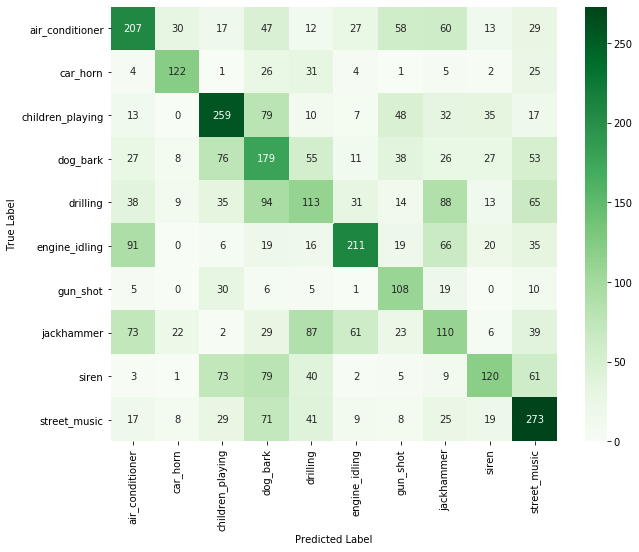

In [88]:
cm  = confusion_matrix(y_test_, y_pred)
plt.figure(figsize= (10,8))
seaborn.heatmap(cm, annot = True, xticklabels= labels, yticklabels = labels, cmap ='Greens', fmt='.3g' )
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [114]:
m3 =  model3()
best_chroma = m3.fit(X_train, y_train, epochs=100, batch_size = 32, validation_data = (X_test, y_test), verbose=1)

Train on 4499 samples, validate on 4233 samples
Epoch 1/100
4499/4499 [==============================] - 3s 761us/sample - loss: 2.1830 - accuracy: 0.1796 - val_loss: 2.0374 - val_accuracy: 0.2169
Epoch 2/100
4499/4499 [==============================] - 1s 320us/sample - loss: 1.8529 - accuracy: 0.2770 - val_loss: 1.8877 - val_accuracy: 0.2627
Epoch 3/100
4499/4499 [==============================] - 1s 274us/sample - loss: 1.7291 - accuracy: 0.3514 - val_loss: 1.8653 - val_accuracy: 0.2996
Epoch 4/100
4499/4499 [==============================] - 1s 298us/sample - loss: 1.6205 - accuracy: 0.3970 - val_loss: 1.8388 - val_accuracy: 0.3265
Epoch 5/100
4499/4499 [==============================] - 1s 283us/sample - loss: 1.5172 - accuracy: 0.4501 - val_loss: 1.8266 - val_accuracy: 0.3265
Epoch 6/100
4499/4499 [==============================] - 1s 327us/sample - loss: 1.4750 - accuracy: 0.4683 - val_loss: 1.7903 - val_accuracy: 0.3657
Epoch 7/100
4499/4499 [==============================] - 2

4499/4499 [==============================] - 2s 362us/sample - loss: 0.6822 - accuracy: 0.7604 - val_loss: 2.7325 - val_accuracy: 0.3966
Epoch 56/100
4499/4499 [==============================] - 1s 325us/sample - loss: 0.6910 - accuracy: 0.7559 - val_loss: 2.7478 - val_accuracy: 0.3933
Epoch 57/100
4499/4499 [==============================] - 1s 285us/sample - loss: 0.6590 - accuracy: 0.7715 - val_loss: 2.7910 - val_accuracy: 0.4191
Epoch 58/100
4499/4499 [==============================] - 1s 289us/sample - loss: 0.6922 - accuracy: 0.7557 - val_loss: 2.9098 - val_accuracy: 0.3759
Epoch 59/100
4499/4499 [==============================] - 1s 290us/sample - loss: 0.6853 - accuracy: 0.7568 - val_loss: 2.5798 - val_accuracy: 0.3938
Epoch 60/100
4499/4499 [==============================] - 1s 320us/sample - loss: 0.6621 - accuracy: 0.7644 - val_loss: 2.7721 - val_accuracy: 0.3978
Epoch 61/100
4499/4499 [==============================] - 1s 333us/sample - loss: 0.6361 - accuracy: 0.7773 - val

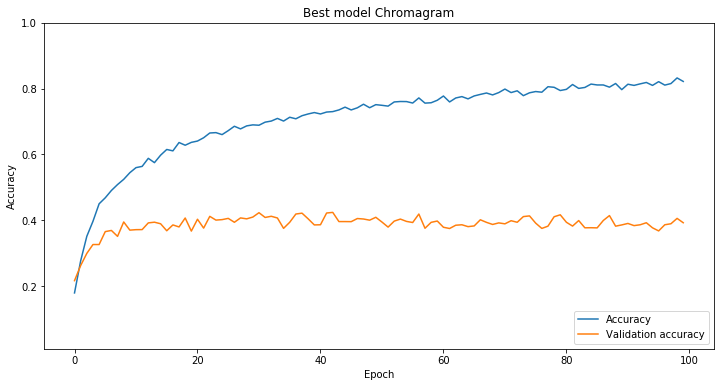

In [115]:
plt.figure(figsize=(12,6))
plt.title("Best model Chromagram")
plt.plot(best_chroma.history['accuracy'], label='Accuracy')
plt.plot(best_chroma.history['val_accuracy'], label = 'Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.01, 1])
plt.legend(loc='lower right')
plt.savefig(os.path.abspath(audio_dataset_path) + '\\' + str('Best_chroma.jpg'))